In [2]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import umap
import ast
import math
import os
import sys
import re
import pickle

from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from datasets import Dataset, load_from_disk

import torch
from torch import nn
from scipy.stats import spearmanr, pearsonr
from scipy.special import betainc

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from performanceUtils import *
from tokenizationUtils import tokenize_batch

## Set-up

In [3]:
sns.set_context("paper", font_scale=1.4)
color_palette = sns.color_palette()
sns.set_style("whitegrid", {'font.family': "arial", "font.size": 10})

general_metrics = ['perplexity_mean', 'perplexity_std', 'perplexity_min', 'perplexity_25', 
    'perplexity_50', 'perplexity_75', 'perplexity_max', 'perplexity_IQR']

### Loading dataset

In [4]:
data = pd.read_csv('../../data/mimic_cxr.csv').dropna()
data = data.loc[data['text'] != ''].reset_index(drop=True)

## Decoder-like models

**Task:** Text generation

**Datasets:** MIMIC-CXR

### Set-up
**Functions**

In [10]:
def explore_results(data, metrics):
    general = []
    for metric in metrics:
        idx_max = data[metric].where(data[metric] == data[metric].max()).dropna().index
        idx_min = data[metric].where(data[metric] == data[metric].min()).dropna().index
        general.append(dict(
            metric=metric,
            best_model=(data.loc[idx_min, 'model'] + '|' + data.loc[idx_min, 'start']).values.tolist(),
            best_value=data[metric].loc[idx_min[0]],
            worst_model=(data.loc[idx_max, 'model'] + '|' + data.loc[idx_max, 'start']).values.tolist(),
            worst_value=data[metric].loc[idx_max[0]],
        ))

    return pd.DataFrame(general)

In [7]:
def corrcoef(matrix):
    r = np.corrcoef(matrix)

    rf = r[np.triu_indices(r.shape[0], 1)]
    df = matrix.shape[1] - 2
    ts = rf * rf * (df / (1 - rf * rf))
    pf = betainc(0.5 * df, 0.5, df / (df + ts))
    p = np.zeros(shape=r.shape)
    p[np.triu_indices(p.shape[0], 1)] = pf
    p[np.tril_indices(p.shape[0], -1)] = p.T[np.tril_indices(p.shape[0], -1)]
    p[np.diag_indices(p.shape[0])] = np.ones(p.shape[0])

    return r, p

**Results**

In [9]:
from tqdm import tqdm

m_list = ["gpt2-medium", "gpt2-large", "gpt2-xl", "open_llama_3b", "open_llama_3b_v2", "open_llama_7b", 
    "open_llama_7b_v2", "gpt-j-6b", "palmyra-base", "falcon-7b", "mpt-7b", "galactica-1.3b", 
    "galactica-6.7b", "gpt-2-pubmed-medium", "gpt-2-pubmed-large", "biogpt", "BioGPT-Large", 
    "open_llama_13b", "llama-7b-hf", "llama-2-7b-hf"]

exclude_text=['.', 'S', '___', '___,', 'None.', 'On', 'Improvement.', '___.', 'Unchanged.', 'Stop', 
    'Unremarkable.', 'Slight', 'Failure.', '___ earlier', 'AS ABOVE', 'AS ABOVE.', 'AS ABOVE..', 
    'As above', 'As above.', 'As above..', 'See above.']

results_decoder = []
perplexities = []
outliers = []

for d in ['mimic-cxr']:
    keep_idx = data[~(data['text'].duplicated() | data['text'].isin(exclude_text))].index
    for i, m in tqdm(enumerate(m_list)):
        file_path = f'../../results/temp/decode_{d}_{m}'
        try:
            d_ = load_from_disk(file_path + '_').select(keep_idx)
            scores = torch.tensor(d_['perplexity'])[:,0:1].numpy()
            d_ = load_from_disk(file_path).select(keep_idx)
            scores = np.hstack([scores, torch.tensor(d_['perplexity'])[:,0:1].numpy()])
        except:
            d_ = load_from_disk(file_path).select(keep_idx)
            scores = torch.tensor(d_['perplexity'])[:,0:1].numpy()
        perplexities.append(scores)
        for pos in range(-scores.shape[1], 0):
            results_decoder.append([f"{m}_{pos+1}", d] + calculate_statistics(scores[:, pos]))
            # Outlier analysis
            _, _, _, _, _, p25, _, p75, _ = results_decoder[-1]
            idx_outliers = np.where(scores[:, pos] > (p75 + 3 * (p75 - p25)))[0]
            count_moderate = len(np.where(scores[:, pos] > (p75 + 1.5 * (p75 - p25)))[0])
            outliers.append([pos + 1, (len(idx_outliers), count_moderate), idx_outliers, 
                scores[idx_outliers, pos]])

results_decoder = pd.DataFrame(results_decoder, columns=['model', 'data', 'perplexity_mean', 
    'perplexity_std', 'perplexity_min', 'perplexity_25', 'perplexity_50', 'perplexity_75', 
    'perplexity_max'])

20it [00:26,  1.31s/it]


In [11]:
col_order = ['model', 'modelID', 'start'] + results_decoder.columns.to_list()[1:-2] + \
    ['perplexity_IQR'] + results_decoder.columns.to_list()[-2:]
results_decoder[['model', 'start']] = list(results_decoder.model.str.split('_').apply(lambda x: ('_'.join(x[:-1]), x[-1])))
models = results_decoder['model'].drop_duplicates().values.tolist()
results_decoder['modelID'] = results_decoder['model'].replace(dict([(m, 'm'+ str(i)) for i, m in enumerate(models)]))
results_decoder['perplexity_IQR'] = results_decoder['perplexity_75'] - results_decoder['perplexity_25']
results_decoder = results_decoder[col_order]

In [12]:
results_decoder.to_csv('../../results/results_decoder.csv', sep='|', index=False)

### A. MIMIC-CXR
#### A.1. General analysis

In [13]:
dataset_name = 'mimic-cxr'

In [14]:
df_results = results_decoder[results_decoder['data'] == dataset_name].copy()
explore_results(df_results[df_results['start'] == '-1'], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,perplexity_mean,[llama-2-7b-hf|-1],9.117028,[biogpt|-1],80.123383
1,perplexity_std,[llama-2-7b-hf|-1],9.977532,[biogpt|-1],1067.224725
2,perplexity_min,[llama-2-7b-hf|-1],2.715459,[biogpt|-1],7.936027
3,perplexity_25,[llama-2-7b-hf|-1],5.861930,[biogpt|-1],24.108150
4,perplexity_50,[llama-2-7b-hf|-1],7.216074,[biogpt|-1],34.142727
5,perplexity_75,[llama-2-7b-hf|-1],9.529202,[biogpt|-1],55.391132
6,perplexity_max,[llama-2-7b-hf|-1],1138.543945,[biogpt|-1],180919.546875
7,perplexity_IQR,[llama-2-7b-hf|-1],3.667271,[biogpt|-1],31.282982


In [15]:
explore_results(df_results[df_results['start'] == '0'], general_metrics)

,metric,best_model,best_value,worst_model,worst_value
0,perplexity_mean,[llama-2-7b-hf|0],8.204699,[biogpt|0],38.722821
1,perplexity_std,[llama-2-7b-hf|0],16.945038,[gpt2-medium|0],941.711563
2,perplexity_min,[open_llama_7b_v2|0],1.798916,[gpt2-medium|0],4.736210
3,perplexity_25,[llama-2-7b-hf|0],5.536794,[biogpt|0],19.817356
4,perplexity_50,[llama-2-7b-hf|0],6.719516,[biogpt|0],27.224781
5,perplexity_75,[llama-2-7b-hf|0],8.568631,[biogpt|0],39.790089
6,perplexity_max,[llama-2-7b-hf|0],3237.900635,[gpt2-medium|0],185627.687500
7,perplexity_IQR,[llama-2-7b-hf|0],3.031837,[biogpt|0],19.972733


#### A.2. Perplexity analysis

General analysis

In [16]:
n = perplexities[0].shape[0]
m = len(m_list)
col_m = np.repeat(m_list, 2*n).reshape(-1,1)
col_s = np.tile(np.repeat(['-1', '0'], n), m).reshape(-1,1)
col_p = np.concatenate([np.concatenate([[[None]]*n, x]) if x.shape[1] == 1 else 
    x.reshape(-1,1,order='F') for x in perplexities])
df_perp = pd.DataFrame(np.concatenate([col_m, col_s, col_p], axis=1), 
    columns=['model', 'start', 'perplexity']).dropna()
df_perp['perplexity'] = pd.to_numeric(df_perp['perplexity'])
df_perp = df_perp.merge(df_results[['model', 'start', 'perplexity_75', 'perplexity_IQR']], 
    on=['model', 'start'])

df_perp['outlier'] = df_perp['perplexity'] > df_perp['perplexity_75'] + 3*df_perp['perplexity_IQR']

In [17]:
df_perp['modelID'] = df_perp['model'].replace({
    'gpt2-medium': 0,
    'gpt2-large': 1,
    'gpt2-xl': 2,
    'gpt-j-6b': 3,
    'palmyra-base': 4,
    'falcon-7b': 5,
    'mpt-7b': 6,
    'open_llama_3b': 7,
    'open_llama_3b_v2': 8,
    'open_llama_7b': 9,
    'open_llama_7b_v2': 10,
    'open_llama_13b': 11,
    'llama-7b-hf': 12,
    'llama-2-7b-hf': 13,
    'gpt-2-pubmed-medium': 14,
    'gpt-2-pubmed-large': 15,
    'biogpt': 16,
    'BioGPT-Large': 17,
    'galactica-1.3b': 18,
    'galactica-6.7b': 19
})
df_perp = df_perp.sort_values(by=['modelID', 'start'])
df_perp['modelID'] = 'm' + df_perp['modelID'].astype(str)

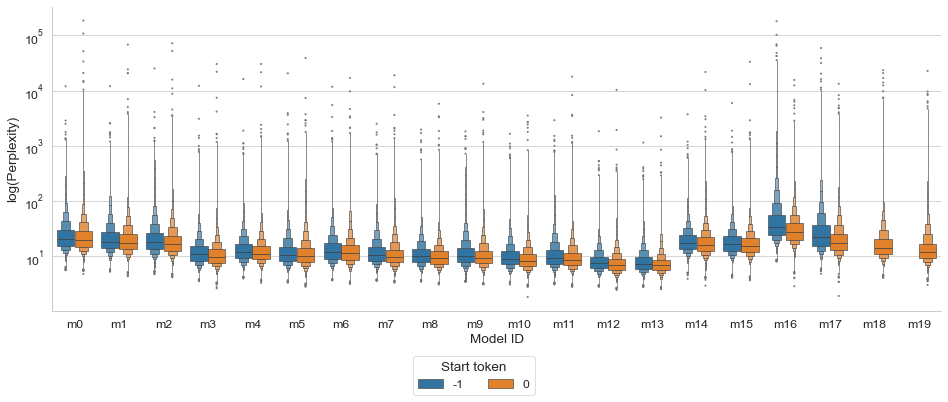

In [18]:
g = sns.catplot(df_perp, kind='boxen', x='modelID', y='perplexity', hue='start', dodge=True, 
    legend=True, zorder=1, sharex=False, margin_titles=False, height=5, aspect= 2.5, log_scale=True,
    gap=0.02, flier_kws={"s": 1.5})
for lh in g._legend.legend_handles: 
    lh.set_alpha(1)
plt.xlabel('Model ID')
plt.ylabel('log(Perplexity)')
plt.tight_layout()
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.125), ncol=6, title='Start token', frameon=True)
plt.savefig('../../results/plots/mimic-cxr_perplexity.png', bbox_inches='tight', dpi=600)

Correlation analysis

In [20]:
m_list = ['GPT2 Medium', 'GPT2 Large', 'GPT2 XL', 'OpeLLaMA 3B', 'OpeLLaMA 3Bv2', 'OpeLLaMA 7B',
    'OpeLLaMA 7Bv2', 'GPT-J 6B', 'Palmyra Base 5B', 'Falcon-7B', 'MPT-7B', 'Galactica 1.3B', 
    'Galactica 6.7B', 'GPT-2-PubMed Medium', 'GPT-2-PubMed Large', 'BioGPT', 'BioGPT-Large', 
    'OpeLLaMA 13B', 'LLaMA-7B', 'LLaMA-7B']
m_list_w = [x for x in m_list if 'Galactica' not in x]

In [19]:
perp_w = []
perp_wo = []

for i, x in enumerate(perplexities):
    perp_wo.append(x[:, -1:])
    if x.shape[1] > 1:
        perp_w.append(x[:,0:1])

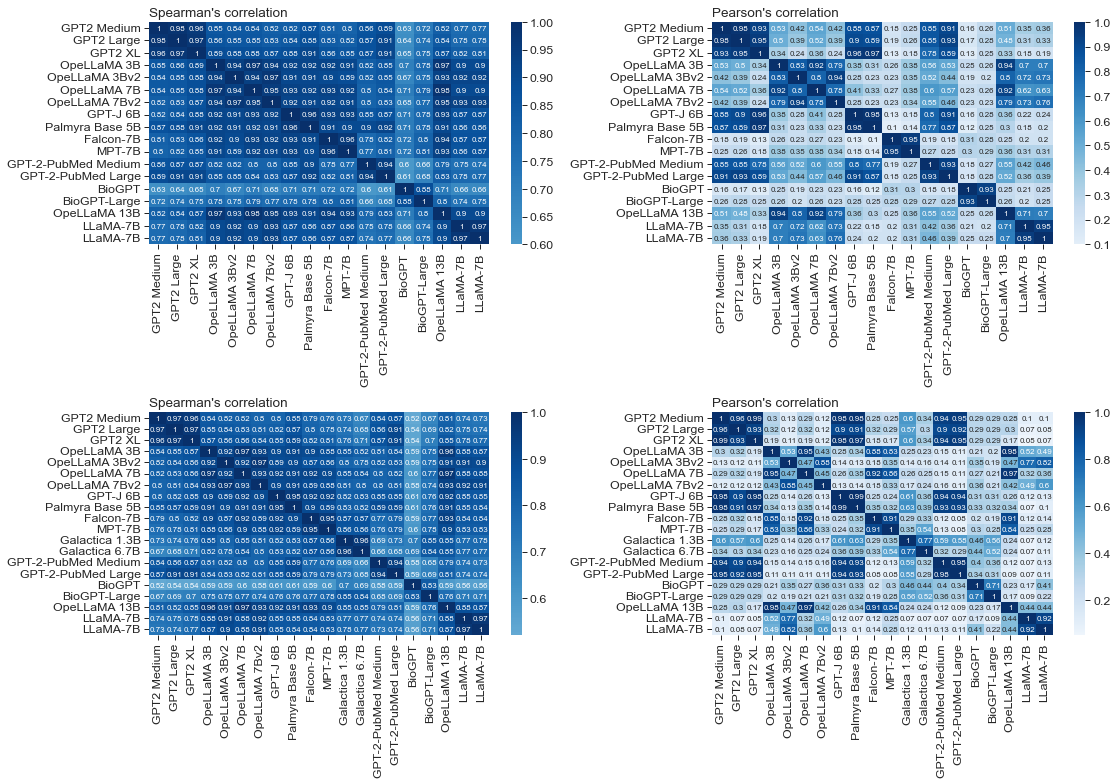

In [21]:
rs = [
    spearmanr(np.hstack(perp_w), axis=0),
    corrcoef(np.hstack(perp_w).T),
    spearmanr(np.delete(np.hstack(perp_wo), [2244, 37174], axis=0), axis=0),
    corrcoef(np.delete(np.hstack(perp_wo), [2244, 37174], axis=0).T)
]
labels = ["Spearman's correlation", "Pearson's correlation"]

sns.set_style("ticks")
fig, ax = plt.subplots(2, 2, figsize=(16,11))
for i, r in enumerate(rs):
    #mask = ~np.tril(np.ones(r[0].shape, dtype=bool))
    ticklabels = m_list_w if i//2 == 0 else m_list
    sns.heatmap(r[0].round(2), annot=True, cmap='Blues', center=0.5, ax=ax[i//2, i%2], 
        xticklabels=ticklabels, yticklabels=ticklabels, annot_kws={'size': 8})
    ax[i//2, i%2].set_title(labels[i%2], loc='left')
plt.tight_layout()
plt.savefig('../../results/plots/mimic-cxr_corr.png', dpi=600)

UMAP analysis

In [22]:
X_wo = umap.UMAP().fit_transform(np.delete(np.hstack(perp_wo), [2244, 37174], axis=0).T)
X_w = umap.UMAP().fit_transform(np.hstack(perp_w).T)

In [23]:
fig = ff.create_dendrogram(X_w, orientation='left', labels=m_list_w)
fig.update_layout(
    xaxis_title="Similarity",
    yaxis_title="Model",
    plot_bgcolor='white',
    font=dict(size =10*1.4, color='black', family='Arial'),
    margin=dict(l=10, r=10, t=10, b=10)
)
fig.update_xaxes(
    showline=True,
    linecolor='black',
    range=[0, 4]
)
fig.update_yaxes(
    showline=True,
    linecolor='black'
)
fig.show()
fig.write_image('../../results/plots/mimic-cxr_UMAP_with.png', scale=2)

fig = ff.create_dendrogram(X_wo, orientation='left', labels=m_list)
fig.update_layout(
    xaxis_title="Similarity",
    yaxis_title="Model",
    plot_bgcolor='white',
    font=dict(size =10*1.4, color='black', family='Arial'),
    margin=dict(l=10, r=10, t=10, b=10)
)
fig.update_xaxes(
    showline=True,
    linecolor='black',
    range=[0, 4]
)
fig.update_yaxes(
    showline=True,
    linecolor='black'
)
fig.show()
fig.write_image('../../results/plots/mimic-cxr_UMAP_without.png', scale=2)

#### A.3. Outlier analysis

General analysis

In [24]:
w_outlier_m_c = []
w_outlier_e_c = []
w_outlier_e_i = []
w_outlier_e_v = []
wo_outlier_m_c = []
wo_outlier_e_c = []
wo_outlier_e_i = []
wo_outlier_e_v = []

for p, c, i, v in outliers:
    if p == -1:
        w_outlier_m_c.append(c[0])
        w_outlier_e_c.append(c[1])
        w_outlier_e_i.append(i)
        w_outlier_e_v.append(v)
    if p == 0:
        wo_outlier_m_c.append(c[0])
        wo_outlier_e_c.append(c[1])
        wo_outlier_e_i.append(i)
        wo_outlier_e_v.append(v)

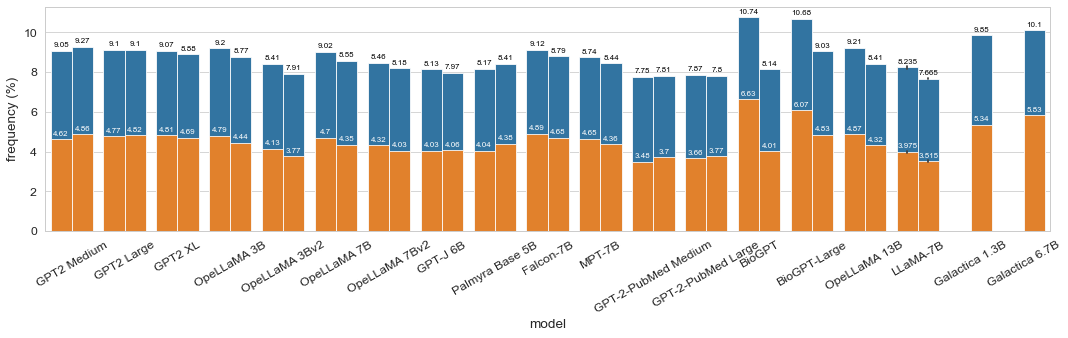

In [26]:
df_counts_w = pd.DataFrame({'model': m_list_w, 'moderate': w_outlier_m_c, 'extreme': w_outlier_e_c})
df_counts_w = df_counts_w.melt(id_vars='model', var_name='outlier type', value_name='frequency')
df_counts_w['frequency'] = ((df_counts_w['frequency'] / n) *100).round(2)
df_counts_w['start'] = -1

df_counts_wo = pd.DataFrame({'model': m_list, 'moderate': wo_outlier_m_c, 'extreme': wo_outlier_e_c})
df_counts_wo = df_counts_wo.melt(id_vars='model', var_name='outlier type', value_name='frequency')
df_counts_wo['frequency'] = ((df_counts_wo['frequency'] / n) *100).round(2)
df_counts_wo['start'] = 0

df_counts = pd.concat([df_counts_w, df_counts_wo])

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(15,4.8))
sns.barplot(data=df_counts[df_counts['outlier type'] == 'extreme'], x='model', hue='start', 
    palette={-1:sns.color_palette()[0], 0:sns.color_palette()[0]}, y='frequency', ax=ax, legend=False)
sns.barplot(data=df_counts[df_counts['outlier type'] == 'moderate'], x='model', hue='start', 
    palette={-1:sns.color_palette()[1], 0:sns.color_palette()[1]}, y='frequency', ax=ax, legend=False)
for i in ax.containers:
    ax.bar_label(i, size=8, color='white' if i.get_label() in ['_container2', '_container3'] else \
        'black', padding=3)
plt.title('', loc='left')
plt.ylabel('frequency (%)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('../../results/plots/mimic-cxr_outliers.png', dpi=600)


UMAP analysis

In [27]:
def create_UMAP(idx, val, n):
    X = np.zeros((n, len(val)))
    for i, v in enumerate(val):
        X[idx[i], i] = v
    X_e_s = umap.UMAP().fit_transform(X[np.where(X.sum(axis=1) != 0)[0]])
    X_e_m = umap.UMAP().fit_transform(X.T)
    return X, X_e_s, X_e_m

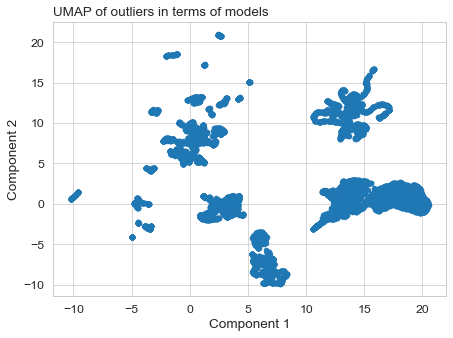

In [29]:
# With BOS token
_, X_embedded_s, X_embedded_m = create_UMAP(w_outlier_e_i, w_outlier_e_v, n)

plt.figure(figsize=(6.4, 4.8))
plt.scatter(X_embedded_s[:, 0], X_embedded_s[:, 1])
plt.title('UMAP of outliers in terms of models', loc='left')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()

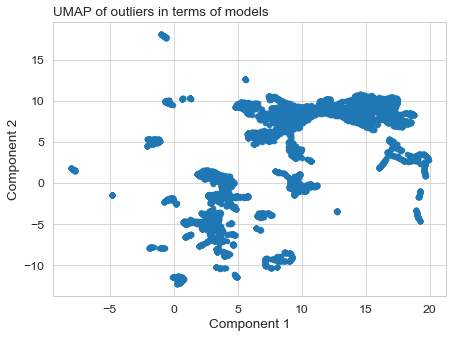

In [30]:
# Without BOS token
_, X_embedded_s, X_embedded_m = create_UMAP(wo_outlier_e_i, wo_outlier_e_v, n)

plt.figure(figsize=(6.4, 4.8))
plt.scatter(X_embedded_s[:, 0], X_embedded_s[:, 1])
plt.title('UMAP of outliers in terms of models', loc='left')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()